In [3]:
import pandas as pd
import numpy as np
import  torch as t
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import pickle 
from IPython.display import clear_output

C:\Users\smits\AppData\Local\Programs\Python\Python312\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
df = pd.read_csv('./NER/ner_dataset.csv',encoding='latin1').drop(['POS'],axis=1)
df['Sentence #'] = df['Sentence #'].str.extract(r'Sentence: (\d+)')
df['Sentence #'] = df['Sentence #'].fillna(0)

In [12]:
df.isnull().sum()

Sentence #    0
Word          0
Tag           0
dtype: int64

In [11]:
df.dropna(axis=0,how='any',inplace=True)

In [3]:
# %%capture
# model_name='sentence-transformers/paraphrase-MiniLM-L6-v2'
# model = SentenceTransformer(model_name)

# def text_to_embeddings(texts,model):
#         embeddings = model.encode(texts, show_progress_bar=True)
#         return embeddings

In [4]:
emb_dic = {}

In [5]:
# for idx,i in enumerate(df['Word'].unique()[15463:]):
#     i = str(i)
#     emb_dic[i] = text_to_embeddings(i,model)
#     if idx % 100 == 0:
#         clear_output(wait=True)
#         print(idx)
# with open('emb_dic.pkl', 'wb') as f:
#     pickle.dump(emb_dic, f)

with open('emb_dic.pkl', 'rb') as f:
    emb_dic = pickle.load(f)

In [26]:
tag_encode = {v:i for i,v in enumerate(df['Tag'].unique())}
tag_decode = {i:v for i,v in enumerate(df['Tag'].unique())}

In [27]:
df['Tag'].unique()

array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

In [31]:
def get_examples(group, n=1):
    return group.sample(n=min(len(group), n))

examples = df.groupby('Tag').apply(get_examples).reset_index(drop=True)
examples.head(examples.shape[0])

C:\Users\smits\AppData\Local\Temp\ipykernel_7180\3248338958.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  examples = df.groupby('Tag').apply(get_examples).reset_index(drop=True)


,Sentence #,Word,Tag
0,0,Facebook,B-art
1,0,Katrina,B-eve
2,0,Kerala,B-geo
3,0,Australian,B-gpe
4,0,AIDS,B-nat
5,0,Pacific,B-org
6,0,Mr.,B-per
7,17007,Wednesday,B-tim
8,0,:,I-art
9,0,Games,I-eve


In [40]:
x_emb = []
y = []
inner_x_emb = []
inner_y = []

for idx,i in enumerate(df.values):
    if i[0]!=0:
        y.append(inner_y)
        x_emb.append(inner_x_emb)
        if i[0]==300:
            break
        inner_y = []
        inner_x_emb = []
    
    if idx % 1000 == 0:
        clear_output(wait=True)
        print(idx/10000)
        
        
    inner_x_emb.append( t.tensor( emb_dic[str(i[1])] ) )
    inner_y.append( t.tensor( tag_encode[i[2]] ) )
    
x_emb.pop(0)
y.pop(0)

104.8


[]

In [61]:
# with open('x_emb.pkl', 'wb') as f:
#     pickle.dump(x_emb, f)
# with open('y.pkl', 'wb') as f:
#     pickle.dump(y, f)

with open('x_emb.pkl', 'rb') as f:
    x_emb = pickle.load(x_emb, f)
with open('y.pkl', 'wb') as f:
    y = pickle.load(y, f)

In [70]:
x_shape = x_emb[0][0][None,:].shape
n_hidden1 = 128
n_hidden2 = 32
num_classes = len(tag_encode.keys())

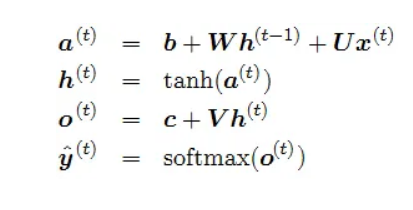

In [42]:
x_shape

torch.Size([1, 384])

In [2]:
# initialise weights
U1 = t.randn(x_shape[1], n_hidden1) * 0.001
b1 = t.zeros(1,n_hidden1)
U2 = t.randn(n_hidden1,n_hidden2) * 0.001
W = t.randn(n_hidden2, n_hidden2) * 0.001
b = t.zeros(1, n_hidden2)  # Initialize biases to zero
# h = t.zeros(1, n_hidden)  # Initialize hidden state to zero

V = t.randn(n_hidden2, num_classes) * 0.001
Vb = t.zeros(num_classes)  # Initialize output bias to zero

parameters = [U1,b1,U2,V,W,b,Vb]
for param in parameters:
    param.requires_grad = True
    
lr = 0.01
losses = []

NameError: name 't' is not defined

In [1]:
for name,param in zip(['U1','b1','U2','V','W','b','Vb'],parameters):
    with open(f'params/{name}.pkl', 'rb') as f:
        param = pickle.load(f)

NameError: name 'parameters' is not defined

In [128]:
# batch gradient decent
for idx,(sx,sy) in enumerate(zip(x_emb[:-148],y[:-148])):

    if idx%478 == 0:
        clear_output(wait=True)
        print(idx/478)
    
    avg_loss = 0
    slen = len(sy)

    h = t.zeros(1, n_hidden2)
    
    for wx,wy in zip(sx,sy):
        # forward
        pa = t.relu((wx @ U1)+b1)
        
        a = ((h @ W)+(pa @ U2)+b)
        h = t.tanh(a)
        o = h @ V + Vb
        o = o.reshape(-1)
        y_hat = t.softmax(o,dim=0)
        loss = -t.log(y_hat[wy])
        avg_loss += loss
    
    # backward
    avg_loss = (1/slen) * avg_loss
    losses.append(avg_loss.item())
    
    for param in parameters:
        if param.grad is not None:
            param.grad.zero_()
    avg_loss.backward()

    # step
    with t.no_grad():
        for param in parameters:
            param -= lr*param.grad

    

99.0


In [138]:
l = [(a+b)/2 for a,b in zip(losses,losses[100:])]
losses = l

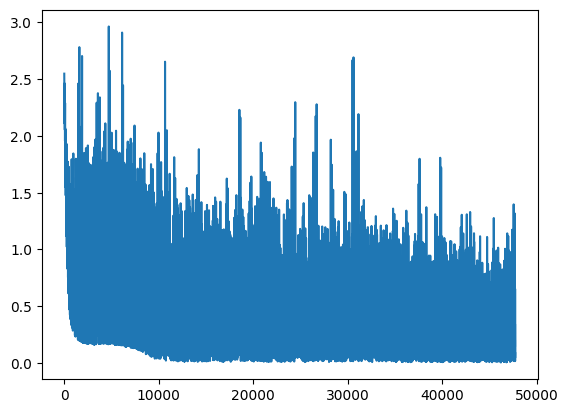

In [139]:
plt.plot(losses)

In [130]:
losses[-1]

0.004325121641159058

In [150]:
for name,param in zip(['U1','b1','U2','V','W','b','Vb'],parameters):
    with open(f'params/{name}.pkl', 'wb') as f:
        pickle.dump(param, f)

In [132]:
%%capture
s_test = 'heloo my name is smit shah, I am from Jamnagar. I am computer science student. I want to go to Germany for further study.'
x_emb_test = [text_to_embeddings(i,model) for i in s_test.split()]
y_test = [0,0,0,0,1,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0]

In [137]:
correct = 0
confidance = 0
num = 0 

for idx,(sx,sy) in enumerate(zip(x_emb[-148:],y[-148:])):
    with t.no_grad():
        
        h = t.zeros(1, n_hidden2)
        
        for wx,wy in zip(sx,sy):
            
            pa = t.relu((wx @ U1)+b1)    
            a = ((h @ W)+(pa @ U2)+b)
            h = t.tanh(a)
            o = h @ V + Vb
            o = o.reshape(-1)
            y_hat = t.softmax(o,dim=0)
            y_hat,conf = t.argmax(y_hat),t.max(y_hat)
            num+=1
            confidance+=conf
            if y_hat==wy:
                correct+=1


correct/num,confidance/num

(0.9382022471910112, tensor(0.9230))